In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 8.1MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 7.9MB/s 


In [2]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-03 17:04:42--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-03 17:04:42--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb7510a7617396f44ea71204553.dl.dropboxusercontent.com/cd/0/get/BJ9gYYDFVhdpX_rGZBM7uuUrDSFlBHSwRNNz66E1ks4Cj-gpT4Sr4lJiAPX4kMvUkEM1SCoWwv-yL3c46qBtSOxmuqzz5WLiDnUlO29r9wJgIMOtl_IT5VlnZnOH3Uge6Fk/file?dl=1# [following]
--2021-03-03 17:04:43--  https://ucb7510a7617396f44ea71204553.dl.dropboxusercontent.com/cd/0/get/BJ9gYYDFVhdpX_rGZBM7uuUrDSFlBHSwRNNz66E1ks4Cj-gpT4Sr4lJiAPX4kMvUkEM1SCoWwv-yL3c46qBtS

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [12]:
modelo='resnest26d'

## Ranger

In [13]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [14]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/gluon_resnest26-50eb607c.pth" to /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth


SuggestedLRs(lr_min=3.6307807022240014e-06, lr_steep=6.309573450380412e-07)

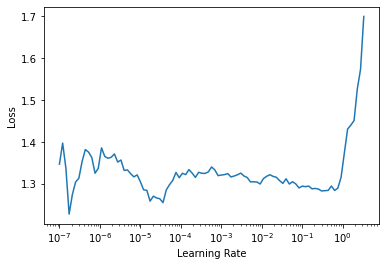

In [15]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.352559,0.996285,0.510703,0.557214,0.326531,00:37
1,1.285932,0.927036,0.527523,0.579439,0.361516,00:35


Better model found at epoch 0 with valid_loss value: 0.9962852597236633.


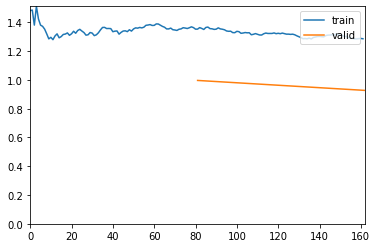

Better model found at epoch 1 with valid_loss value: 0.9270362257957458.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.201473,0.915921,0.527523,0.569672,0.405248,00:44
1,1.248561,0.890191,0.524465,0.557971,0.448980,00:43
2,1.190797,0.898643,0.551988,0.593985,0.460641,00:42
3,1.127255,0.853807,0.561162,0.605263,0.469388,00:43
4,1.140132,0.877200,0.547401,0.618090,0.358601,00:42
5,1.076399,0.839434,0.567278,0.610294,0.483965,00:42
6,1.079304,0.825613,0.576453,0.626923,0.475219,00:42
7,1.057947,0.831426,0.553517,0.612335,0.405248,00:43
8,1.042100,0.810787,0.573394,0.629032,0.454810,00:42
9,1.051752,0.805320,0.561162,0.608527,0.457726,00:42


Better model found at epoch 0 with valid_loss value: 0.9159209728240967.


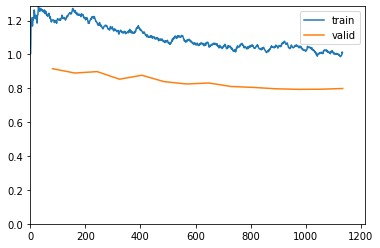

Better model found at epoch 1 with valid_loss value: 0.8901907801628113.
Better model found at epoch 3 with valid_loss value: 0.853807270526886.
Better model found at epoch 5 with valid_loss value: 0.8394336104393005.
Better model found at epoch 6 with valid_loss value: 0.8256128430366516.
Better model found at epoch 8 with valid_loss value: 0.8107874989509583.
Better model found at epoch 9 with valid_loss value: 0.8053200840950012.
Better model found at epoch 10 with valid_loss value: 0.7973060607910156.
Better model found at epoch 11 with valid_loss value: 0.7939309477806091.
No improvement since epoch 11: early stopping


In [16]:
learn.fine_tune(15,freeze_epochs=2)

In [17]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

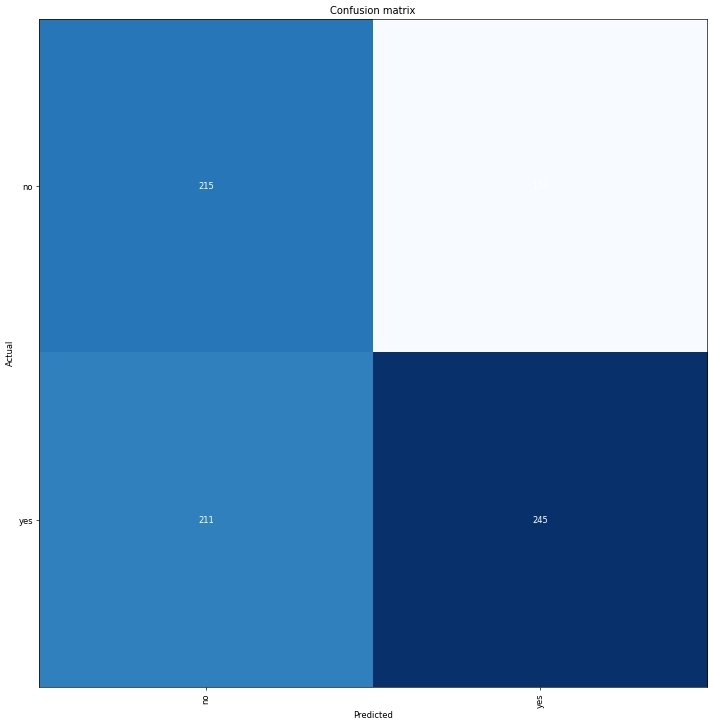

In [18]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [19]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5700123906135559.


(#4) [0.7662916779518127,0.5700123906135559,0.6430446194225722,0.5372807017543859]

## Faltten

In [20]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.308042,0.808346,0.571865,0.596330,0.568513,00:35
1,1.014839,0.737094,0.577982,0.626415,0.483965,00:35


Better model found at epoch 0 with valid_loss value: 0.8083459734916687.


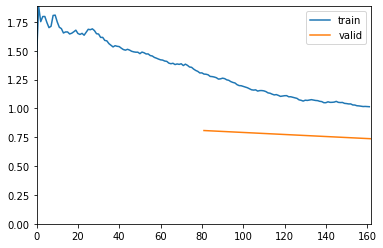

Better model found at epoch 1 with valid_loss value: 0.7370938658714294.


In [21]:
learn.fit_flat_cos(2,lr=1e-3)

In [22]:
learn.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.9054607491852948e-06)

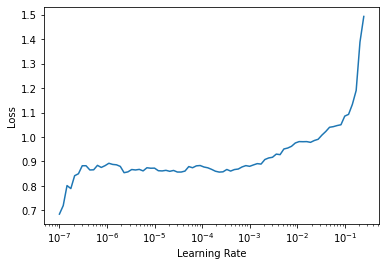

In [23]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.050202,1.096018,0.475535,0.000000,0.000000,00:42
1,0.978713,4.109223,0.512232,0.530151,0.615160,00:42
2,0.954145,2.100992,0.477064,0.571429,0.011662,00:42
3,0.952392,0.707169,0.474006,0.400000,0.005831,00:41
4,1.013351,0.707682,0.475535,0.000000,0.000000,00:42
5,1.020165,33.797153,0.524465,0.524465,1.000000,00:42
6,0.992147,0.724901,0.527523,0.526480,0.985423,00:41


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 1.0960179567337036.


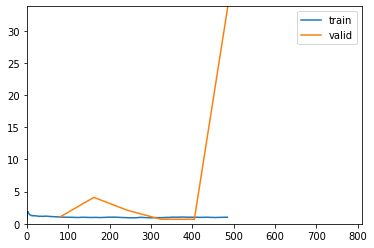

Better model found at epoch 3 with valid_loss value: 0.7071690559387207.
No improvement since epoch 3: early stopping


In [24]:
learn.fit_flat_cos(10,lr=1e-2)

In [25]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

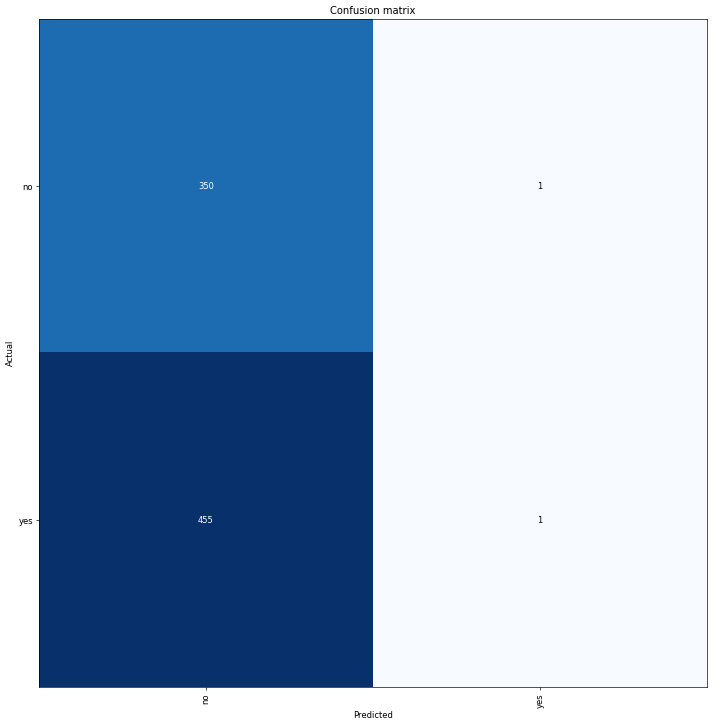

In [26]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [27]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.7054914832115173,0.4349442422389984,0.5,0.0021929824561403508]

## LabelSmoothing

In [28]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=5.754399353463669e-07, lr_steep=1.0964781722577754e-06)

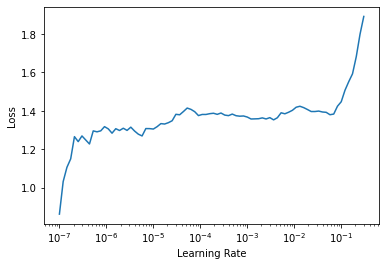

In [29]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.315870,1.196728,0.553517,0.552577,0.781341,00:35
1,1.052681,0.804574,0.547401,0.615764,0.364431,00:35


Better model found at epoch 0 with valid_loss value: 1.1967281103134155.


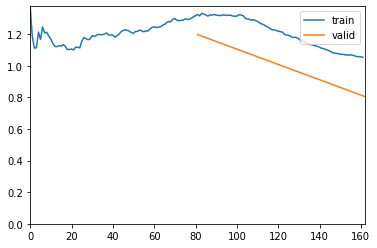

Better model found at epoch 1 with valid_loss value: 0.8045743107795715.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.759203,0.697329,0.561162,0.585890,0.556851,00:42
1,0.761478,0.703182,0.588685,0.623333,0.545190,00:42
2,0.721250,0.685542,0.576453,0.580488,0.693878,00:42
3,0.690691,0.673784,0.597859,0.588106,0.778426,00:43
4,0.681618,0.656006,0.616208,0.661972,0.548105,00:42
5,0.646508,0.667843,0.623853,0.605206,0.813411,00:42
6,0.646693,0.639945,0.634557,0.692593,0.545190,00:42
7,0.608448,0.632530,0.681957,0.750929,0.588921,00:42
8,0.596133,0.696455,0.620795,0.736318,0.431487,00:42
9,0.590516,0.648002,0.654434,0.769585,0.486880,00:42


Better model found at epoch 0 with valid_loss value: 0.6973293423652649.


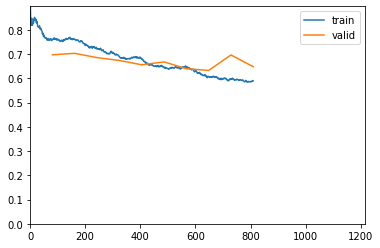

Better model found at epoch 2 with valid_loss value: 0.6855420470237732.
Better model found at epoch 3 with valid_loss value: 0.6737836599349976.
Better model found at epoch 4 with valid_loss value: 0.6560056209564209.
Better model found at epoch 6 with valid_loss value: 0.6399446725845337.
Better model found at epoch 7 with valid_loss value: 0.6325297951698303.
No improvement since epoch 7: early stopping


In [30]:
learn.fine_tune(15,freeze_epochs=2)

In [31]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

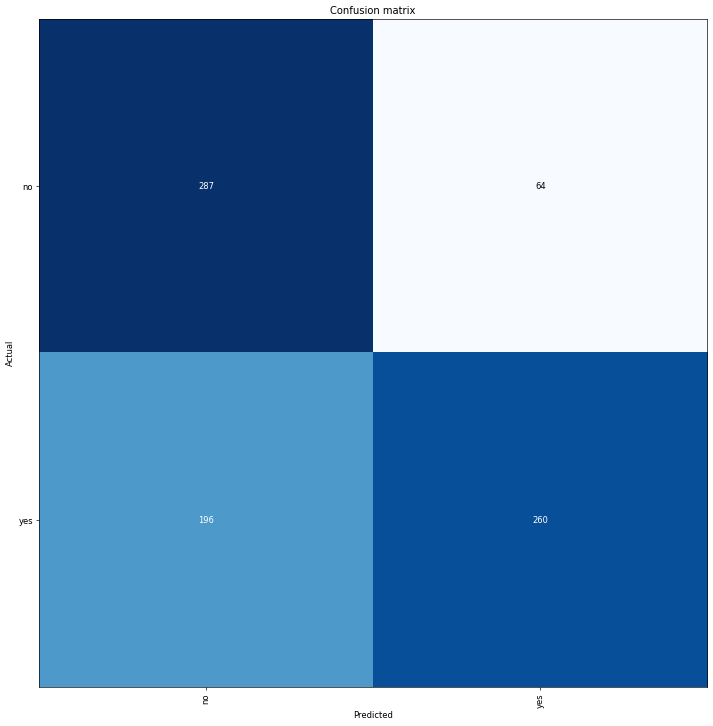

In [32]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [33]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6778190732002258.


(#4) [0.6023619771003723,0.6778190732002258,0.8024691358024691,0.5701754385964912]

## MixUp

In [39]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [40]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.332730,1.702647,0.503058,0.593750,0.166181,00:35
1,1.094831,0.824422,0.551988,0.549213,0.813411,00:35


Better model found at epoch 0 with valid_loss value: 1.70264732837677.


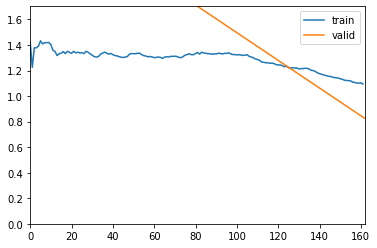

Better model found at epoch 1 with valid_loss value: 0.824422299861908.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.824129,0.693798,0.588685,0.591133,0.699708,00:42
1,0.790305,0.712673,0.550459,0.652174,0.306122,00:42
2,0.746928,0.763416,0.519878,0.652632,0.180758,00:42
3,0.724755,0.652519,0.622324,0.690476,0.507289,00:43
4,0.695966,0.643625,0.623853,0.676364,0.542274,00:43
5,0.663478,0.641723,0.634557,0.714876,0.504373,00:43
6,0.657618,0.731106,0.576453,0.800000,0.256560,00:42
7,0.646718,0.717986,0.594801,0.795455,0.306122,00:42
8,0.627849,0.711787,0.613150,0.840909,0.323615,00:42


Better model found at epoch 0 with valid_loss value: 0.6937977075576782.


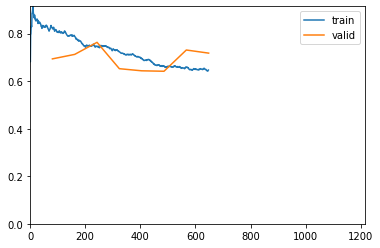

Better model found at epoch 3 with valid_loss value: 0.652518630027771.
Better model found at epoch 4 with valid_loss value: 0.6436249613761902.
Better model found at epoch 5 with valid_loss value: 0.6417232155799866.
No improvement since epoch 5: early stopping


In [41]:
learn.fine_tune(15,freeze_epochs=2)

In [42]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

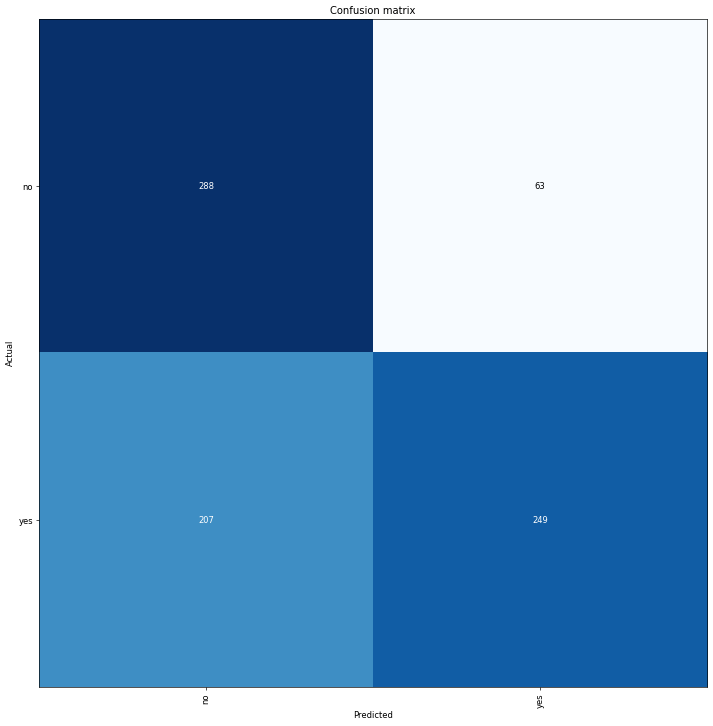

In [43]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [44]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6654275059700012.


(#4) [0.6169255375862122,0.6654275059700012,0.7980769230769231,0.5460526315789473]

## Ranger + Flat cosin Anneal

In [45]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.318066,0.925331,0.463303,0.488372,0.489796,00:35
1,1.307631,0.894067,0.484709,0.508380,0.530612,00:35


Better model found at epoch 0 with valid_loss value: 0.9253308773040771.


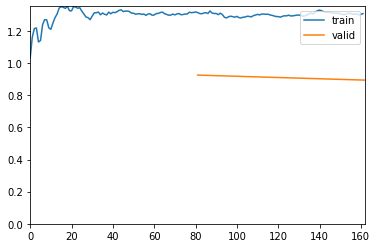

Better model found at epoch 1 with valid_loss value: 0.8940672278404236.


In [46]:
learn.fit_flat_cos(2,lr=1e-3)

In [47]:
learn.unfreeze()

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=9.12010818865383e-07)

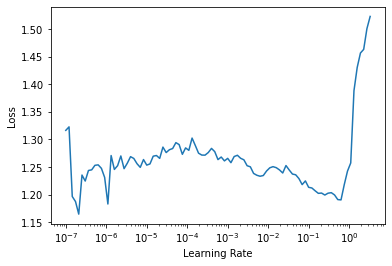

In [48]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.136109,0.781867,0.573394,0.580000,0.676385,00:42
1,1.010642,0.750965,0.571865,0.606780,0.521866,00:43
2,0.914961,0.715410,0.587156,0.594805,0.667638,00:42
3,0.827701,0.710605,0.579511,0.574890,0.760933,00:42
4,0.725940,0.651617,0.634557,0.648571,0.661808,00:42
5,0.695548,0.639033,0.626911,0.656151,0.606414,00:42
6,0.652001,0.620824,0.663609,0.745020,0.545190,00:42
7,0.626399,0.588244,0.700306,0.718101,0.705539,00:42
8,0.610301,0.592796,0.677370,0.704969,0.661808,00:42
9,0.581886,0.600549,0.672783,0.710098,0.635569,00:42


Better model found at epoch 0 with valid_loss value: 0.7818671464920044.


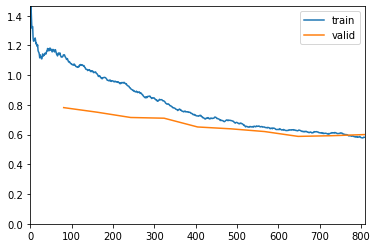

Better model found at epoch 1 with valid_loss value: 0.7509647011756897.
Better model found at epoch 2 with valid_loss value: 0.7154102325439453.
Better model found at epoch 3 with valid_loss value: 0.7106045484542847.
Better model found at epoch 4 with valid_loss value: 0.6516173481941223.
Better model found at epoch 5 with valid_loss value: 0.6390334367752075.
Better model found at epoch 6 with valid_loss value: 0.6208235025405884.
Better model found at epoch 7 with valid_loss value: 0.5882439017295837.


In [49]:
learn.fit_flat_cos(10,lr=1e-2)

In [50]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [51]:
learn.dls = dlsTest

In [52]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7112763524055481.


(#4) [0.5625506639480591,0.7112763524055481,0.7866323907455013,0.6710526315789473]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [53]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.309861,0.868400,0.521407,0.541899,0.565598,00:35
1,1.268574,0.840957,0.518349,0.541420,0.533528,00:35


Better model found at epoch 0 with valid_loss value: 0.8684004545211792.


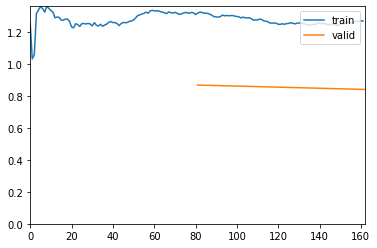

Better model found at epoch 1 with valid_loss value: 0.8409566879272461.


In [54]:
learn.fit_flat_cos(2,lr=1e-3)

In [55]:
learn.unfreeze()

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=3.981071586167673e-06)

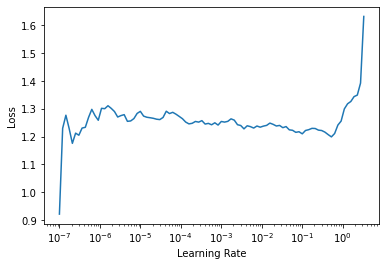

In [56]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.153279,0.854323,0.513761,0.532982,0.588921,00:42
1,1.002306,0.787430,0.516820,0.558442,0.376093,00:42
2,0.916406,0.699799,0.626911,0.637883,0.667638,00:42
3,0.823283,0.664146,0.642202,0.708812,0.539359,00:43
4,0.741442,0.664067,0.620795,0.686275,0.510204,00:42
5,0.692738,0.647596,0.640673,0.710938,0.530612,00:42
6,0.645702,0.626199,0.655963,0.692810,0.618076,00:42
7,0.633805,0.625708,0.674312,0.721088,0.618076,00:42
8,0.616772,0.620219,0.685015,0.703264,0.690962,00:42
9,0.602675,0.605173,0.691131,0.705539,0.705539,00:42


Better model found at epoch 0 with valid_loss value: 0.8543227910995483.


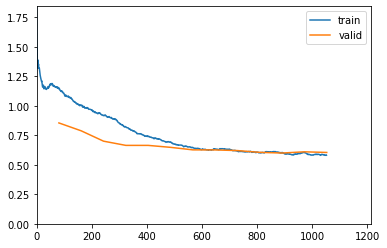

Better model found at epoch 1 with valid_loss value: 0.7874303460121155.
Better model found at epoch 2 with valid_loss value: 0.6997988820075989.
Better model found at epoch 3 with valid_loss value: 0.6641457676887512.
Better model found at epoch 4 with valid_loss value: 0.6640669107437134.
Better model found at epoch 5 with valid_loss value: 0.6475955843925476.
Better model found at epoch 6 with valid_loss value: 0.6261988878250122.
Better model found at epoch 7 with valid_loss value: 0.6257076263427734.
Better model found at epoch 8 with valid_loss value: 0.6202187538146973.
Better model found at epoch 9 with valid_loss value: 0.6051726937294006.
Better model found at epoch 10 with valid_loss value: 0.5993909239768982.
No improvement since epoch 10: early stopping


In [57]:
learn.fit_flat_cos(15,lr=1e-2)

In [58]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [59]:
learn.dls = dlsTest

In [60]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.727385401725769.


(#4) [0.5681058764457703,0.727385401725769,0.8121693121693122,0.6732456140350878]

## Ranger +Flat + Label + MixUp

In [61]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.253848,0.828225,0.544343,0.562674,0.588921,00:35
1,1.217649,0.825471,0.556575,0.569921,0.629738,00:35


Better model found at epoch 0 with valid_loss value: 0.8282254934310913.


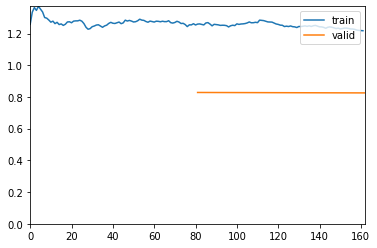

Better model found at epoch 1 with valid_loss value: 0.8254711031913757.


In [62]:
learn.fit_flat_cos(2,lr=1e-3)

In [63]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.147643,0.783198,0.551988,0.558685,0.693878,00:43
1,1.041392,0.753190,0.501529,0.525680,0.507289,00:42
2,0.933789,0.687112,0.573394,0.598160,0.568513,00:42
3,0.831716,0.695361,0.545872,0.558974,0.635569,00:42
4,0.774155,0.672435,0.576453,0.590164,0.629738,00:42
5,0.725869,0.666990,0.603976,0.687500,0.448980,00:43
6,0.697831,0.651376,0.594801,0.625806,0.565598,00:42
7,0.686588,0.665426,0.591743,0.686275,0.408163,00:43
8,0.678177,0.647738,0.611621,0.692641,0.466472,00:43
9,0.669998,0.641241,0.642202,0.693950,0.568513,00:42


Better model found at epoch 0 with valid_loss value: 0.7831981778144836.


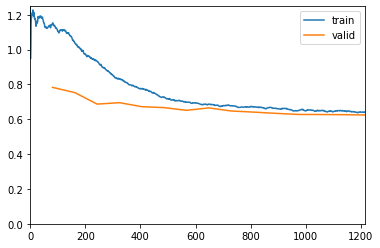

Better model found at epoch 1 with valid_loss value: 0.753189742565155.
Better model found at epoch 2 with valid_loss value: 0.6871122121810913.
Better model found at epoch 4 with valid_loss value: 0.6724350452423096.
Better model found at epoch 5 with valid_loss value: 0.6669896245002747.
Better model found at epoch 6 with valid_loss value: 0.6513757109642029.
Better model found at epoch 8 with valid_loss value: 0.647737979888916.
Better model found at epoch 9 with valid_loss value: 0.6412408351898193.
Better model found at epoch 10 with valid_loss value: 0.634111225605011.
Better model found at epoch 11 with valid_loss value: 0.6277661919593811.
Better model found at epoch 12 with valid_loss value: 0.6273202896118164.
Better model found at epoch 13 with valid_loss value: 0.6265612840652466.
Better model found at epoch 14 with valid_loss value: 0.6246219873428345.


In [64]:
learn.fit_flat_cos(15,lr=1e-2)

In [65]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

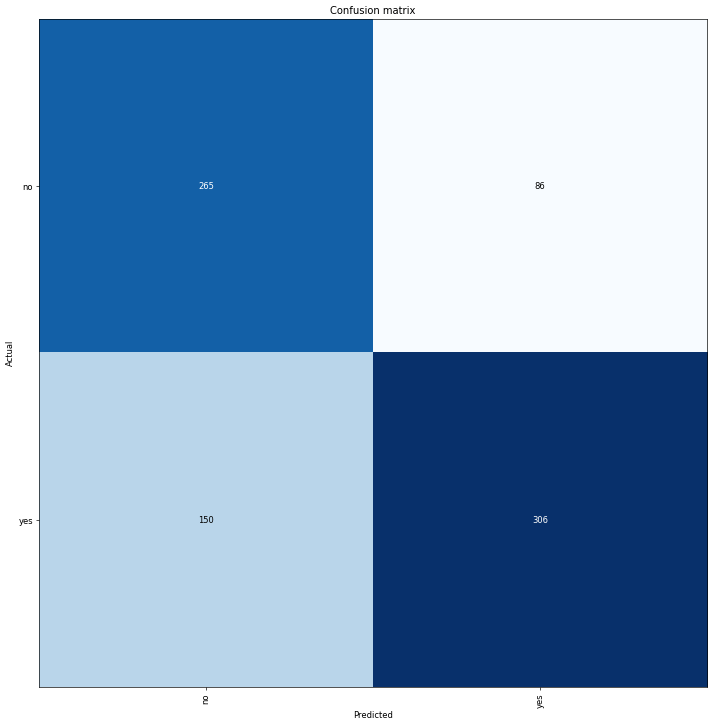

In [66]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [67]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7075588703155518.


(#4) [0.5933590531349182,0.7075588703155518,0.7806122448979592,0.6710526315789473]

## Ranger + Flat + MixUp

In [68]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [69]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.376688,0.957082,0.500000,0.525806,0.475219,00:36
1,1.363968,0.922481,0.498471,0.526690,0.431487,00:36


Better model found at epoch 0 with valid_loss value: 0.9570819139480591.


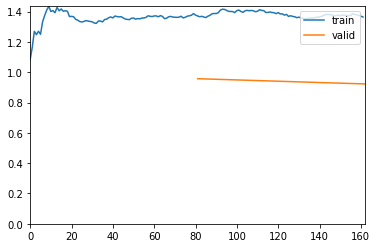

Better model found at epoch 1 with valid_loss value: 0.9224808812141418.


In [70]:
learn.fit_flat_cos(2,lr=1e-3)

In [71]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.271714,0.807080,0.501529,0.533333,0.396501,00:43
1,1.140485,0.810775,0.547401,0.554524,0.696793,00:43
2,0.980169,0.743351,0.538226,0.562691,0.536443,00:43
3,0.901510,0.712995,0.562691,0.591640,0.536443,00:43
4,0.826835,0.690727,0.551988,0.586207,0.495627,00:43
5,0.765886,0.686162,0.568807,0.581769,0.632653,00:43
6,0.720258,0.700189,0.542813,0.674603,0.247813,00:43
7,0.703280,0.673009,0.551988,0.588028,0.486880,00:43
8,0.694734,0.665584,0.573394,0.646789,0.411079,00:42
9,0.681727,0.649114,0.587156,0.668203,0.422741,00:43


Better model found at epoch 0 with valid_loss value: 0.8070800304412842.


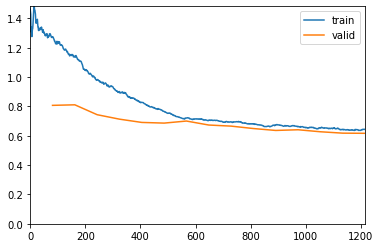

Better model found at epoch 2 with valid_loss value: 0.74335116147995.
Better model found at epoch 3 with valid_loss value: 0.7129946947097778.
Better model found at epoch 4 with valid_loss value: 0.6907272934913635.
Better model found at epoch 5 with valid_loss value: 0.6861624717712402.
Better model found at epoch 7 with valid_loss value: 0.6730092167854309.
Better model found at epoch 8 with valid_loss value: 0.6655835509300232.
Better model found at epoch 9 with valid_loss value: 0.6491144299507141.
Better model found at epoch 10 with valid_loss value: 0.6360985040664673.
Better model found at epoch 12 with valid_loss value: 0.6271594762802124.
Better model found at epoch 13 with valid_loss value: 0.6176527738571167.
Better model found at epoch 14 with valid_loss value: 0.616637647151947.


In [72]:
learn.fit_flat_cos(15,lr=1e-2)

In [73]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [74]:
learn.dls = dlsTest

In [75]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6517967581748962.


(#4) [0.6149247288703918,0.6517967581748962,0.8326996197718631,0.48026315789473684]

## Ranger + MixUp

In [76]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [77]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.379865,0.997952,0.518349,0.529536,0.731778,00:35
1,1.305233,0.924437,0.513761,0.527964,0.688047,00:35


Better model found at epoch 0 with valid_loss value: 0.9979522228240967.


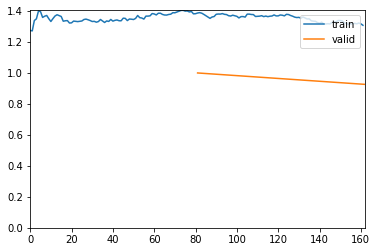

Better model found at epoch 1 with valid_loss value: 0.9244368672370911.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.277443,0.918489,0.524465,0.533755,0.737609,00:43
1,1.264921,0.900904,0.532110,0.539957,0.728863,00:43
2,1.233063,0.868278,0.535168,0.542670,0.723032,00:43
3,1.181813,0.853796,0.515290,0.529279,0.685131,00:43
4,1.155843,0.832788,0.536697,0.544248,0.717201,00:43
5,1.123882,0.841605,0.524465,0.535398,0.705539,00:43
6,1.126505,0.805267,0.542813,0.556122,0.635569,00:43
7,1.104615,0.805912,0.548930,0.555300,0.702624,00:43
8,1.060617,0.792771,0.541284,0.557641,0.606414,00:42
9,1.076954,0.784119,0.550459,0.562982,0.638484,00:43


Better model found at epoch 0 with valid_loss value: 0.9184890389442444.


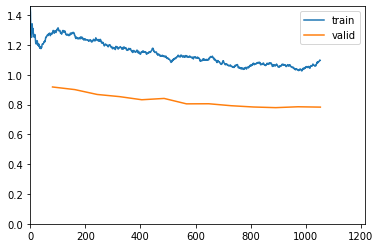

Better model found at epoch 1 with valid_loss value: 0.90090411901474.
Better model found at epoch 2 with valid_loss value: 0.8682778477668762.
Better model found at epoch 3 with valid_loss value: 0.8537960052490234.
Better model found at epoch 4 with valid_loss value: 0.8327882289886475.
Better model found at epoch 6 with valid_loss value: 0.8052665591239929.
Better model found at epoch 8 with valid_loss value: 0.7927711606025696.
Better model found at epoch 9 with valid_loss value: 0.7841193079948425.
Better model found at epoch 10 with valid_loss value: 0.77974534034729.
No improvement since epoch 10: early stopping


In [78]:
learn.fine_tune(15,freeze_epochs=2)

In [79]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [80]:
learn.dls = dlsTest

In [81]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5824039578437805.


(#4) [0.7303568720817566,0.5824039578437805,0.6337078651685393,0.618421052631579]

## Faltten + MixUp

In [82]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.306864,0.831823,0.522936,0.567686,0.379009,00:35
1,0.970753,0.706796,0.558104,0.598540,0.478134,00:35


Better model found at epoch 0 with valid_loss value: 0.8318228721618652.


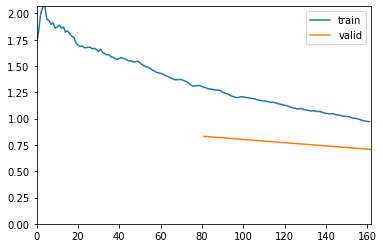

Better model found at epoch 1 with valid_loss value: 0.7067957520484924.


In [83]:
learn.fit_flat_cos(2,lr=1e-3)

In [84]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.023413,4.739983,0.500000,0.564516,0.204082,00:42
1,0.982941,0.742187,0.524465,0.524465,1.000000,00:42
2,1.067050,7.788722,0.493884,0.553571,0.180758,00:41
3,1.035396,2.257474,0.503058,0.545000,0.317784,00:42
4,1.051177,2.797753,0.480122,0.504673,0.472303,00:42


Better model found at epoch 0 with valid_loss value: 4.739982604980469.


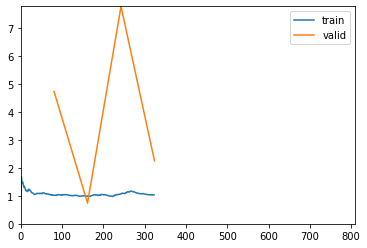

Better model found at epoch 1 with valid_loss value: 0.7421865463256836.
No improvement since epoch 1: early stopping


In [85]:
learn.fit_flat_cos(10,lr=1e-2)

In [86]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [87]:
learn.dls = dlsTest

In [88]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.7120959758758545,0.565055787563324,0.5650557620817844,1.0]

## Ranger + Label

In [89]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [90]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.291294,0.878258,0.489297,0.512535,0.536443,00:35
1,1.288236,0.842948,0.501529,0.530249,0.434402,00:35


Better model found at epoch 0 with valid_loss value: 0.8782581686973572.


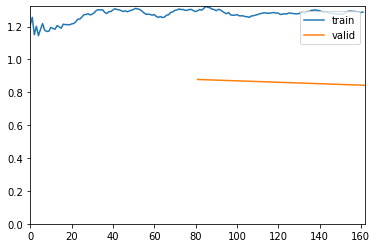

Better model found at epoch 1 with valid_loss value: 0.8429481387138367.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.190626,0.839676,0.521407,0.554745,0.443149,00:42
1,1.207625,0.825785,0.510703,0.539249,0.460641,00:42
2,1.190327,0.825054,0.513761,0.540984,0.481050,00:42
3,1.161698,0.824557,0.509174,0.538462,0.448980,00:42
4,1.115489,0.805298,0.510703,0.538721,0.466472,00:42
5,1.095002,0.806820,0.507645,0.539924,0.413994,00:42
6,1.097427,0.789930,0.518349,0.551471,0.437318,00:42
7,1.061177,0.803344,0.506116,0.538760,0.405248,00:42
8,1.059999,0.778518,0.529052,0.561404,0.466472,00:42
9,1.081933,0.778119,0.532110,0.569288,0.443149,00:43


Better model found at epoch 0 with valid_loss value: 0.8396762013435364.


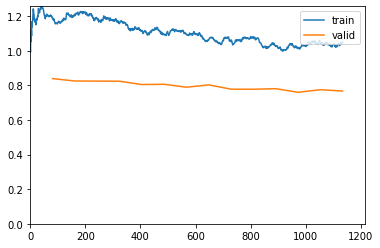

Better model found at epoch 1 with valid_loss value: 0.825785219669342.
Better model found at epoch 2 with valid_loss value: 0.8250535726547241.
Better model found at epoch 3 with valid_loss value: 0.8245565891265869.
Better model found at epoch 4 with valid_loss value: 0.8052979707717896.
Better model found at epoch 6 with valid_loss value: 0.7899303436279297.
Better model found at epoch 8 with valid_loss value: 0.7785184383392334.
Better model found at epoch 9 with valid_loss value: 0.7781190276145935.
Better model found at epoch 11 with valid_loss value: 0.7604833245277405.
No improvement since epoch 11: early stopping


In [91]:
learn.fine_tune(15,freeze_epochs=2)

In [92]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [93]:
learn.dls = dlsTest

In [94]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5551425218582153.


(#4) [0.7388373017311096,0.5551425218582153,0.6246786632390745,0.5328947368421053]

## Faltten + Label

In [95]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.261408,0.959918,0.553517,0.652695,0.317784,00:35
1,0.955320,0.833116,0.550459,0.681481,0.268222,00:35


Better model found at epoch 0 with valid_loss value: 0.9599182605743408.


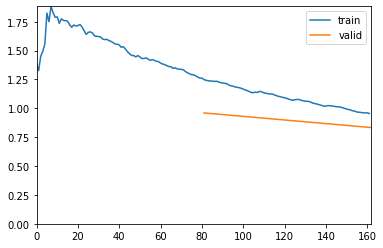

Better model found at epoch 1 with valid_loss value: 0.8331159949302673.


In [96]:
learn.fit_flat_cos(2,lr=1e-3)

In [97]:
learn.unfreeze()

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=4.786300905834651e-06)

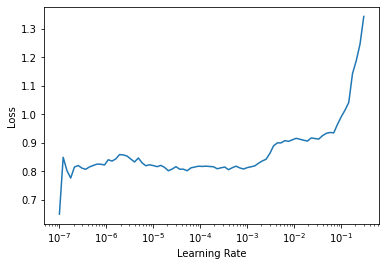

In [98]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.953832,0.925694,0.516820,0.522241,0.924198,00:42
1,0.933133,8.308389,0.472477,0.496835,0.457726,00:41
2,0.982981,0.697455,0.475535,0.000000,0.000000,00:42
3,1.017565,10.521881,0.525994,0.525581,0.988338,00:42
4,1.028027,0.723513,0.475535,0.000000,0.000000,00:41
5,1.006577,0.692220,0.524465,0.524465,1.000000,00:42
6,0.988223,0.724648,0.475535,0.000000,0.000000,00:42
7,0.970120,0.695068,0.524465,0.524465,1.000000,00:42
8,0.909550,0.692645,0.524465,0.524465,1.000000,00:41


Better model found at epoch 0 with valid_loss value: 0.9256941676139832.


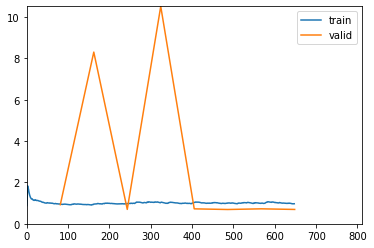

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with valid_loss value: 0.6974552869796753.
Better model found at epoch 5 with valid_loss value: 0.6922204494476318.
No improvement since epoch 5: early stopping


In [99]:
learn.fit_flat_cos(10,lr=1e-2)

In [100]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [101]:
learn.dls = dlsTest

In [102]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.565055787563324.


(#4) [0.6883221864700317,0.565055787563324,0.5650557620817844,1.0]

## Label + MixUp

In [103]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.362655,1.117875,0.516820,0.564593,0.344023,00:35
1,1.105427,0.786016,0.556575,0.563246,0.688047,00:35


Better model found at epoch 0 with valid_loss value: 1.1178754568099976.


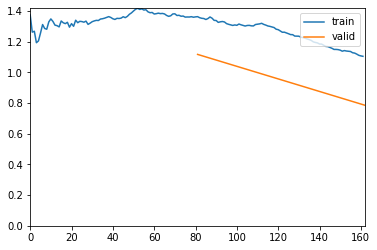

Better model found at epoch 1 with valid_loss value: 0.7860158681869507.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.820858,0.724200,0.541284,0.574394,0.483965,00:42
1,0.782771,0.711401,0.548930,0.580000,0.507289,00:42
2,0.745238,0.678054,0.577982,0.572985,0.766764,00:42
3,0.714832,0.680191,0.582569,0.612903,0.553936,00:42
4,0.683534,0.688354,0.587156,0.691099,0.384840,00:43
5,0.674941,0.654456,0.639144,0.698885,0.548105,00:42
6,0.670119,0.630679,0.665138,0.692547,0.650146,00:42
7,0.656300,0.631674,0.651376,0.657534,0.699708,00:42
8,0.638499,0.683703,0.625382,0.806250,0.376093,00:42
9,0.642243,0.643291,0.631498,0.738318,0.460641,00:42


Better model found at epoch 0 with valid_loss value: 0.7242003679275513.


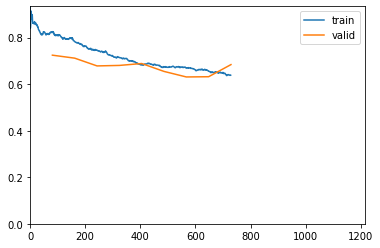

Better model found at epoch 1 with valid_loss value: 0.7114007472991943.
Better model found at epoch 2 with valid_loss value: 0.6780542135238647.
Better model found at epoch 5 with valid_loss value: 0.6544556021690369.
Better model found at epoch 6 with valid_loss value: 0.6306787729263306.
No improvement since epoch 6: early stopping


In [104]:
learn.fine_tune(15,freeze_epochs=2)

In [105]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [106]:
learn.dls = dlsTest

In [107]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6964064240455627.


(#4) [0.6008220314979553,0.6964064240455627,0.7617866004962779,0.6732456140350878]